# Transformer

The Transformer model is also based on the encoder-decoder architecture. It,
however, differs to the seq2seq model that the transformer replaces the
recurrent layers in seq2seq with attention layers. To deal with sequential
inputs, each item in the sequential is copied as the query, the key and the
value as illustrated in :numref:`fig_self_attention`. It therefore outputs a same length
sequential output. We call such an attention layer as a self-attention layer.

![Self-attention architecture.](../img/self-attention.svg)

:label:`fig_self_attention`



<!-- Compared to a recurrent layer, output items of a self-attention layer can be computed in parallel and, therefore, it is easy to obtain a high-efficient implementation. -->

The transformer architecture, with a comparison to the seq2seq model with
attention, is shown in :numref:`fig_transformer`. These two models are similar to
each other in overall: the source sequence embeddings are fed into $n$ repeated
blocks. The outputs of the last block are then used as attention memory for the
decoder.  The target sequence embeddings is similarly fed into $n$ repeated
blocks in the decoder, and the final outputs are obtained by applying a dense
layer with vocabulary size to the last block's outputs.

![The transformer architecture.](../img/transformer.svg)

:label:`fig_transformer`


It can also be seen that the transformer differs to the seq2seq with attention model in three major places:

1. A recurrent layer in seq2seq is replaced with a transformer block. This block contains a self-attention layer (muti-head attention) and a network with two dense layers (position-wise FFN) for the encoder. For the decoder, another mut-head attention layer is used to take the encoder state.
1. The encoder state is passed to every transformer block in the decoder, instead of using as an additional input of the first recurrent layer in seq2seq.
1. Since the self-attention layer does not distinguish the item order in a sequence, a positional encoding layer is used to add sequential information into each sequence item.

In the rest of this section, we will explain every new layer introduced by the transformer, and construct a model to train on the machine translation dataset.

In [1]:
import math
import d2l
from mxnet import nd, autograd
from mxnet.gluon import nn

## Multi-Head Attention

A multi-head attention layer consists of $h$ parallel attention layers, each one is called a head. For each head, we use three dense layers with hidden sizes $p_q$, $p_k$ and $p_v$ to project the queries, keys and values, respectively, before feeding into the attention layer. The outputs of these $h$ heads are concatenated and then projected by another dense layer.

![Multi-head attention](../img/multi-head-attention.svg)

To be more specific, assume we have the learnable parameters
$\mathbf W_q^{(i)}\in\mathbb R^{p_q\times d_q}$,
$\mathbf W_k^{(i)}\in\mathbb R^{p_k\times d_k}$,
and $\mathbf W_v^{(i)}\in\mathbb R^{p_v\times d_v}$,
 for $i=1,\ldots,h$, and $\mathbf W_o\in\mathbb R^{d_o\times h p_v}$. Then the output for each head can be obtained by

$$\mathbf o^{(i)} = \textrm{attention}(\mathbf W_q^{(i)}\mathbf q, \mathbf W_k^{(i)}\mathbf k,\mathbf W_v^{(i)}\mathbf v),$$

where $\text{attention}$ can be any attention layer introduced before. Since we already have learnable parameters, the simple dot product attention is used.

Then we concatenate all outputs and project them to obtain the multi-head attention output

$$\mathbf o = \mathbf W_o \begin{bmatrix}\mathbf o^{(1)}\\\vdots\\\mathbf o^{(h)}\end{bmatrix}.$$

In practice, we often use $p_q=p_k=p_v=d_o/h$. The hyper-parameters for a multi-head attention, therefore, contain the number heads $h$, and output feature size $d_o$.

In [2]:
class MultiHeadAttention(nn.Block):
    def __init__(self, units, num_heads, dropout, **kwargs):  # units = d_o
        super(MultiHeadAttention, self).__init__(**kwargs)
        assert units % num_heads == 0
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Dense(units, use_bias=False, flatten=False)
        self.W_k = nn.Dense(units, use_bias=False, flatten=False)
        self.W_v = nn.Dense(units, use_bias=False, flatten=False)

    # query, key, and value shape: (batch_size, num_items, dim)
    # valid_length shape is either (bathc_size, ) or (batch_size, num_items)
    def forward(self, query, key, value, valid_length):
        # Project and transpose from (batch_size, num_items, units) to
        # (batch_size * num_heads, num_items, p), where units = p * num_heads.
        query, key, value = [transpose_qkv(X, self.num_heads) for X in (
            self.W_q(query), self.W_k(key), self.W_v(value))]
        if valid_length is not None:
            # Copy valid_length by num_heads times
            if valid_length.ndim == 1:
                valid_length = valid_length.tile(self.num_heads)
            else:
                valid_length = valid_length.tile((self.num_heads, 1))
        output = self.attention(query, key, value, valid_length)
        # Transpose from (batch_size * num_heads, num_items, p) back to
        # (batch_size, num_items, units)
        return transpose_output(output, self.num_heads)

Here are the definitions of the transpose functions.

In [3]:
def transpose_qkv(X, num_heads):
    # Shape after reshape: (batch_size, num_items, num_heads, p)
    # 0 means copying the shape element, -1 means inferring its value
    X = X.reshape((0, 0, num_heads, -1))
    # Swap the num_items and the num_heads dimensions
    X = X.transpose((0, 2, 1, 3))
    # Merge the first two dimensions. Use reverse=True to infer
    # shape from right to left
    return X.reshape((-1, 0, 0), reverse=True)

def transpose_output(X, num_heads):
    # A reversed version of transpose_qkv
    X = X.reshape((-1, num_heads, 0, 0), reverse=True)
    X = X.transpose((0, 2, 1, 3))
    return X.reshape((0, 0, -1))

Create a multi-head attention with the output size $d_o$ equals to 100, the output will share the same batch size and sequence length as the input, but the last dimension will be equal to $d_o$.

In [4]:
cell = MultiHeadAttention(100, 10, 0.5)
cell.initialize()
X = nd.ones((2, 4, 5))
valid_length = nd.array([2,3])
cell(X, X, X, valid_length).shape

(2, 4, 100)

## Position-wise Feed-Forward Networks


The position-wise feed-forward network accepts a 3-dim input with shape (batch size, sequence length, feature size). It consists of two dense layers that applies to the last dimension, which means the same dense layers are used for each position item in the sequence, so called position-wise.

In [5]:
class PositionWiseFFN(nn.Block):
    def __init__(self, units, hidden_size, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.ffn_1 = nn.Dense(hidden_size, flatten=False, activation='relu')
        self.ffn_2 = nn.Dense(units, flatten=False)

    def forward(self, X):
        return self.ffn_2(self.ffn_1(X))

Similar to the muti-head attention, the position-wise feed-forward network will only change the last dimension size of the input. In addition, if two items in the input sequence are identical, the according outputs will be identical as well.

In [6]:
ffn = PositionWiseFFN(4, 8)
ffn.initialize()
ffn(nd.ones((2, 3, 4)))[0]


[[ 0.00752072  0.00865059  0.01013744 -0.00906538]
 [ 0.00752072  0.00865059  0.01013744 -0.00906538]
 [ 0.00752072  0.00865059  0.01013744 -0.00906538]]
<NDArray 3x4 @cpu(0)>

## Add and Norm

The input and the output of a multi-head attention layer or a position-wise feed-forward network are combined by a block that contains a residual structure and a layer normalization layer.

Layer normalization is similar batch normalization, but the mean and variances are calculated along the last dimension, e.g `X.mean(axis=-1)` instead of the first batch dimension, e.g. `X.mean(axis=0)`.

In [7]:
layer = nn.LayerNorm()
layer.initialize()
batch = nn.BatchNorm()
batch.initialize()
X = nd.array([[1,2],[2,3]])
# compute mean and variance from X in the training mode.
with autograd.record():
    print('layer norm:',layer(X), '\nbatch norm:', batch(X))

layer norm: 
[[-0.99998  0.99998]
 [-0.99998  0.99998]]
<NDArray 2x2 @cpu(0)> 
batch norm: 
[[-0.99998 -0.99998]
 [ 0.99998  0.99998]]
<NDArray 2x2 @cpu(0)>


The connection block accepts two inputs $X$ and $Y$, the input and output of an other block. Within this connection block, we apply dropout on $Y$.

In [8]:
class AddNorm(nn.Block):
    def __init__(self, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm()

    def forward(self, X, Y):
        return self.norm(self.dropout(Y) + X)

Due to the residual connection, $X$ and $Y$ should have the same shape.

In [9]:
add_norm = AddNorm(0.5)
add_norm.initialize()
add_norm(nd.ones((2,3,4)), nd.ones((2,3,4))).shape

(2, 3, 4)

## Positional Encoding

Unlike the recurrent layer, both the multi-head attention layer and the position-wise feed-forward network compute the output of each item in the sequence independently. This property allows us to parallel the computation but is inefficient to model the sequence information. The transformer model therefore adds positional information into the input sequence.

Assume $X\in\mathbb R^{l\times d}$ is the embedding of an example, where $l$ is the sequence length and $d$ is the embedding size. This layer will create a positional encoding $P\in\mathbb R^{l\times d}$ and output $P+X$, with $P$ defined as following:

$$P_{i,2j} = \sin(i/10000^{2j/d}),\quad P_{i,2j+1} = \cos(i/10000^{2j/d}),$$

for $i=0,\ldots,l-1$ and $j=0,\ldots,\lfloor(d-1)/2\rfloor$.

In [10]:
class PositionalEncoding(nn.Block):
    def __init__(self, units, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = nd.zeros((1, max_len, units))
        X = nd.arange(0, max_len).reshape((-1,1)) / nd.power(
            10000, nd.arange(0, units, 2)/units)
        self.P[:, :, 0::2] = nd.sin(X)
        self.P[:, :, 1::2] = nd.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].as_in_context(X.context)
        return self.dropout(X)


Now we visualize the position values for 4 dimensions. As can be seen, the 4th dimension has the same frequency as the 5th but with different offset. The 5th and 6th dimension have a lower frequency.

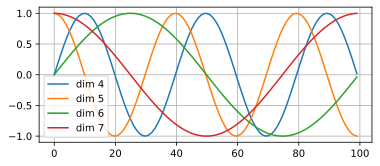

In [11]:
pe = PositionalEncoding(20, 0)
pe.initialize()
Y = pe(nd.zeros((1, 100, 20 )))
d2l.plot(nd.arange(100), Y[0, :,4:8].T, figsize=(6, 2.5),
        legend=["dim %d"%p for p in [4,5,6,7]])

## Encoder

Now we define the transformer block for the encoder, which contains a multi-head attention layer, a position-wise feed-forward network, and two connection blocks.

In [12]:
class EncoderBlock(nn.Block):
    def __init__(self, units, hidden_size, num_heads, dropout, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(units, num_heads, dropout)
        self.add_1 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(units, hidden_size)
        self.add_2 = AddNorm(dropout)

    def forward(self, X, valid_length):
        Y = self.add_1(X, self.attention(X, X, X, valid_length))
        return self.add_2(Y, self.ffn(Y))

Due to the residual connections, this block will not change the input shape. It means the `units` argument should be equal to the input's last dimension size.

In [13]:
encoder_blk = EncoderBlock(24, 48, 8, 0.5)
encoder_blk.initialize()
encoder_blk(nd.ones((2, 100, 24)), valid_length).shape

(2, 100, 24)

The encoder stacks $n$ blocks. Due to the residual connection again, the embedding layer size $d$ is same as the transformer block output size. Also note that we multiple the embedding output by $\sqrt{d}$ to avoid its values are too small compared to positional encodings.

In [14]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, units, hidden_size,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.units = units
        self.embed = nn.Embedding(vocab_size, units)
        self.pos_encoding = PositionalEncoding(units, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add(
                EncoderBlock(units, hidden_size, num_heads, dropout))

    def forward(self, X, valid_length, *args):
        X = self.pos_encoding(self.embed(X) * math.sqrt(self.units))
        for blk in self.blks:
            X = blk(X, valid_length)
        return X

Create an encoder with two transformer blocks, whose hyper-parameters are same as before.

In [15]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
encoder.initialize()
encoder(nd.ones((2, 100)), valid_length).shape

(2, 100, 24)

## Decoder

Let first look at how a decoder behaviors during predicting. Similar to the seq2seq model, we call $T$ forwards to generate a $T$ length sequence. At time step $t$, assume $\mathbf x_t$ is the current input, i.e. the query. Then keys and values of the self-attention layer consist of the current query with all past queries $\mathbf x_1, \ldots, \mathbf x_{t-1}$.

![Predict at time step $t$ for a self-attention layer.](../img/self-attention-predict.svg)

During training, because the output for the $t$-query could depend all $T$ key-value pairs, which results in an inconsistent behavior than prediction. We can eliminate it by specifying the valid length to be $t$ for the $t$-th query.

Another difference compared to the encoder transformer block is that the decoder block has an additional multi-head attention layer that accepts the encoder outputs as keys and values.

In [16]:
class DecoderBlock(nn.Block):
    # i means it's the i-th block in the decoder
    def __init__(self, units, hidden_size, num_heads, dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention_1 = MultiHeadAttention(units, num_heads, dropout)
        self.add_1 = AddNorm(dropout)
        self.attention_2 = MultiHeadAttention(units, num_heads, dropout)
        self.add_2 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(units, hidden_size)
        self.add_3 = AddNorm(dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lengh = state[0], state[1]
        # state[2][i] contains the past queries for this block
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = nd.concat(state[2][self.i], X, dim=1)
        state[2][self.i] = key_values
        if autograd.is_training():
            batch_size, seq_len, _ = X.shape
            # shape: (batch_size, seq_len), the values in the j-th column
            # are j+1
            valid_length = nd.arange(
                1, seq_len+1, ctx=X.context).tile((batch_size, 1))
        else:
            valid_length = None

        X2 = self.attention_1(X, key_values, key_values, valid_length)
        Y = self.add_1(X, X2)
        Y2 = self.attention_2(Y, enc_outputs, enc_outputs, enc_valid_lengh)
        Z = self.add_2(Y, Y2)
        return self.add_3(Z, self.ffn(Z)), state

Similar to the encoder block, `units` should be equal to the last dimension size of $X$.

In [17]:
decoder_blk = DecoderBlock(24, 48, 8, 0.5, 0)
decoder_blk.initialize()
X = nd.ones((2, 100, 24))
state = [encoder_blk(X, valid_length), valid_length, [None]]
decoder_blk(X, state)[0].shape

(2, 100, 24)

The construction of the decoder is identical to the encoder except for the additional last dense layer to obtain confident scores.

In [18]:
class TransformerDecoder(d2l.Decoder):
    def __init__(self, vocab_size, units, hidden_size,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.units = units
        self.num_layers = num_layers
        self.embed = nn.Embedding(vocab_size, units)
        self.pos_encoding = PositionalEncoding(units, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add(
                DecoderBlock(units, hidden_size, num_heads, dropout, i))
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, env_valid_lengh, *args):
        return [enc_outputs, env_valid_lengh, [None]*self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embed(X) * math.sqrt(self.units))
        for blk in self.blks:
            X, state = blk(X, state)
        return self.dense(X), state

## Training

We use similar hyper-parameters as for the seq2seq with attention model: two transformer blocks with both the embedding size and the block output size to be 32. The additional hyper-parameters are chosen as 4 heads with the hidden size to be 2 times larger than output size.

loss 0.031, 4889 tokens/sec on gpu(0) 


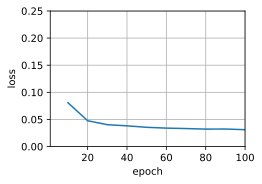

In [19]:
embed_size, units, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_steps = 64, 10
lr, num_epochs, ctx = 0.005, 100, d2l.try_gpu()
num_hiddens, num_heads = 64, 4

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), units, num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(
    len(src_vocab), units, num_hiddens, num_heads, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
d2l.train_s2s_ch8(model, train_iter, lr, num_epochs, ctx)

Compared to the seq2seq model with attention model, the transformer runs faster per epoch, and converges faster at the beginning.

Finally, we translate three sentences.

In [20]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + d2l.predict_s2s_ch8(
        model, sentence, src_vocab, tgt_vocab, num_steps, ctx))

Go . => va !
Wow ! => <unk> !
I'm OK . => je vais bien .
I won ! => j'ai gagné !


## Summary

* Transformer model is based on N*N encoder-decoder architecture. It differs from Seq2seq with attention in 3 major places.
* Multi-head attention layer contains $h$ parallel attention layers.
* Position-wise feed-forward network equals to apply 2 $Conv(1,1)$ layers.
* Layer normalization differs from batch normalization by normalizaing along the last dimension (the feature dimension) instead of the first (batchsize) dimension.
* Positional encoding is the only place that adds positional information to the transformer model.